# CSV --> Graph Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file. 

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, IngestionGenerator, LLM, PyIngest
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Initialize Test Data

The USER_GENERATED_INPUT variable contains a General Discription and feature descriptions for each feature we'd like to use in our graph.

In [6]:
USER_GENERATED_INPUT = {
    'general_description': 'This is data on different countries.',
    'id': 'unique id for a country.',
    'name': 'the country name.',
    'phone_code': 'country area code.',
    'capital': 'the capital of the country.',
    'currency_name': "name of the country's currency.",
    'region': 'primary region of the country.',
    'subregion': 'subregion location of the country.',
    'timezones': 'timezones contained within the country borders.',
    'latitude': 'the latitude coordinate of the country center.',
    'longitude': 'the longitude coordinate of the country center.'
}

In [7]:
data = pd.read_csv("data/csv/countries.csv")

## Initialize LLM

We now initialize the LLM to use in data discovery and data model creation.

In [8]:
llm = LLM()

## Discovery

We now load the above data into a Discovery object.

In [9]:
disc = Discovery(llm=llm, user_input=USER_GENERATED_INPUT, data=data)

In [10]:
discovery = disc.run()
print(discovery)

Based on the provided summary and description of the data, here is a preliminary analysis:

### Overall Details:
1. **Data Completeness**:
   - The dataset contains 250 entries (countries) and 10 features.
   - Most features are complete, but there are some missing values:
     - `capital`: 5 missing values.
     - `region`: 2 missing values.
     - `subregion`: 3 missing values.

2. **Data Types**:
   - The dataset includes a mix of data types:
     - Numerical: `id`, `latitude`, `longitude`.
     - Categorical: `name`, `phone_code`, `capital`, `currency_name`, `region`, `subregion`, `timezones`.

3. **Unique Values**:
   - `name`: All 250 entries are unique.
   - `phone_code`: 235 unique values, with the most common code appearing 3 times.
   - `capital`: 244 unique values, with one capital appearing twice.
   - `currency_name`: 161 unique values, with "Euro" being the most common (35 occurrences).
   - `region`: 6 unique values, with "Africa" being the most common (60 occurrences).


## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [12]:
gdm = GraphDataModeler(
    llm=llm,
    user_input=USER_GENERATED_INPUT,
    discovery=disc
)

We now generate our first pass data model.

In [13]:
initial_model = gdm.create_initial_model()

recieved a valid response


In [14]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='capitalName', type='str', csv_mapping='capital', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='regionName', type='str', csv_mapping='region', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(name='subregionName', type='str', csv_mapping='subregion', is_unique=True, part_of_key=False)], csv_name=''), Node(label='PhoneCode', properties=[Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=True, part_of_key=False)], csv_name='')

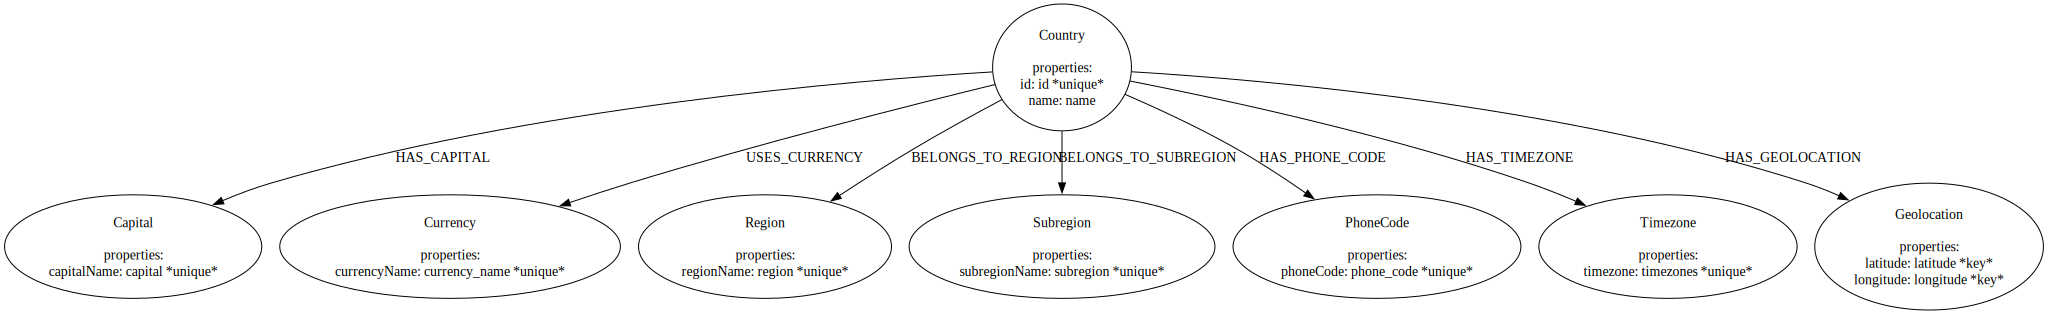

In [15]:
gdm.current_model.visualize()

This doesn't look quite right, so let's prompt the LLM to make some corrections.

In [19]:
gdm.iterate_model(iterations=1, user_corrections="Make Region node have a HAS_SUBREGION relationship with Subregion node. Remove The relationship between Country and Region. Both the latitude and longitude properties on Geolocation should be node keys.")

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='capitalName', type='str', csv_mapping='capital', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='regionName', type='str', csv_mapping='region', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(name='subregionName', type='str', csv_mapping='subregion', is_unique=True, part_of_key=False)], csv_name=''), Node(label='PhoneCode', properties=[Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=True, part_of_key=False)], csv_name='')

In [20]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='capitalName', type='str', csv_mapping='capital', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='regionName', type='str', csv_mapping='region', is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(name='subregionName', type='str', csv_mapping='subregion', is_unique=True, part_of_key=False)], csv_name=''), Node(label='PhoneCode', properties=[Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=True, part_of_key=False)], csv_name='')

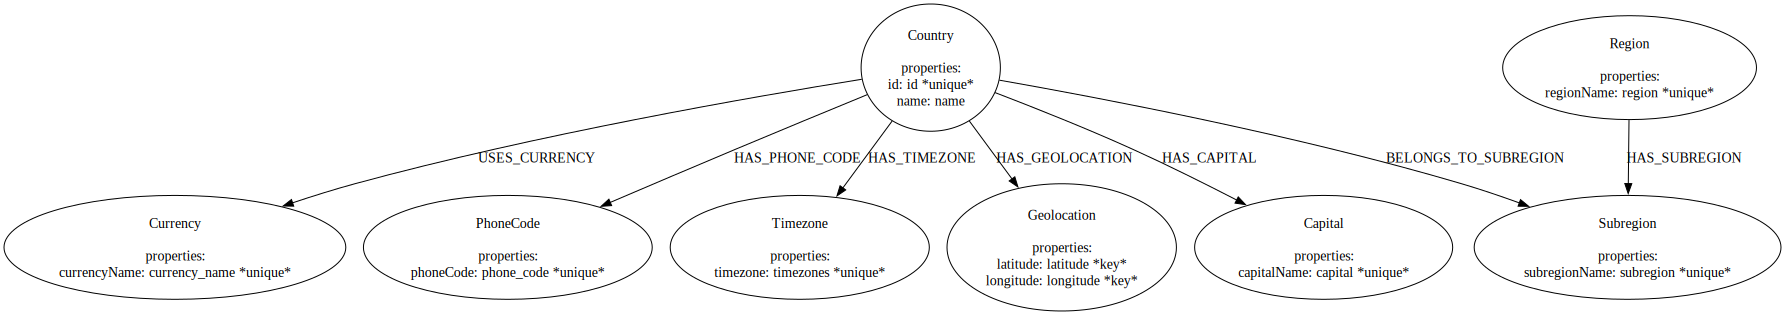

In [21]:
gdm.current_model.visualize()

This is good enough for our demo. We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We should provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [22]:

gen = IngestionGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         csv_dir="data/csv/", csv_name="countries.csv")

In [23]:
pyingest_yaml = gen.generate_pyingest_yaml_string()
# gen.generate_pyingest_yaml_file(file_name="countries")
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT capital_capitalname IF NOT EXISTS FOR (n:Capital) REQUIRE n.capitalName IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
  - CREATE CONSTRAINT region_regionname IF NOT EXISTS FOR (n:Region) REQUIRE n.regionName IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregionname IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregionName IS UNIQUE;
  - CREATE CONSTRAINT phonecode_phonecode IF NOT EXISTS FOR (n:PhoneCode) REQUIRE n.phoneCode IS UNIQUE;
  - CREATE CONSTRAINT timezone_timezone IF NOT EXISTS FOR (n:Timezone) REQUIRE n.timezone IS UNIQUE;
  - CREATE CONSTRAINT geolocation_latitude_longitude IF NOT EXISTS FOR (n:Geolocation) REQUIRE (n.latitude, n.longitude) IS NODE KEY;
files:
- chunk_size: 100
  cql

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. This version of PyIngest works only with pre-loaded Pandas DataFrames. First let's confirm our connection though.

In [24]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [26]:
PyIngest(yaml_string=pyingest_yaml, dataframe=data)

File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:23.860265
loading... 1 2024-05-20 14:05:23.936473
{} : Completed file 2024-05-20 14:05:23.958260
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:23.958827
loading... 1 2024-05-20 14:05:23.990325
{} : Completed file 2024-05-20 14:05:24.008697
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.009208
loading... 1 2024-05-20 14:05:24.038214
{} : Completed file 2024-05-20 14:05:24.056043
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.056455


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py

loading... 1 2024-05-20 14:05:24.083988
{} : Completed file 2024-05-20 14:05:24.095477
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.095866
loading... 1 2024-05-20 14:05:24.129623
{} : Completed file 2024-05-20 14:05:24.141679
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.142192
loading... 1 2024-05-20 14:05:24.171952
{} : Completed file 2024-05-20 14:05:24.190068
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.190598
loading... 1 2024-05-20 14:05:24.221659
{} : Completed file 2024-05-20 14:05:24.240913
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.241376
loading... 1 2024-05-20 14:05:24.270959
{} : Completed file 2024-05-20 14:05:24.289059
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.289576


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py

loading... 1 2024-05-20 14:05:24.327192
{} : Completed file 2024-05-20 14:05:24.343518
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.344110
loading... 1 2024-05-20 14:05:24.378096
{} : Completed file 2024-05-20 14:05:24.396121
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.396630
loading... 1 2024-05-20 14:05:24.431194
{} : Completed file 2024-05-20 14:05:24.447650
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.448132
loading... 1 2024-05-20 14:05:24.499250
{} : Completed file 2024-05-20 14:05:24.517146
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.517540


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py

loading... 1 2024-05-20 14:05:24.552907
{} : Completed file 2024-05-20 14:05:24.573239
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.573867
loading... 1 2024-05-20 14:05:24.628128
{} : Completed file 2024-05-20 14:05:24.652196
File {} .//data/csv/countries.csv
loading... 0 2024-05-20 14:05:24.652724
loading... 1 2024-05-20 14:05:24.684485
{} : Completed file 2024-05-20 14:05:24.695933


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.2.0.png](./images/countries-graph-0.2.0.png)